# Walmart Model Training Workflow

A guided notebook to prepare features, train a baseline model, and evaluate forecasts for Walmart weekly sales data.

## Objectives

- Load engineered features (or regenerate them on demand).
- Produce time-aware train/validation/test splits for a selected store.
- Fit a RandomForest baseline and report MAE, RMSE, and MAPE.
- Persist the trained artifacts for downstream pipelines.

In [9]:
from __future__ import annotations

import sys
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from hydra.utils import instantiate
from omegaconf import OmegaConf

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.figsize": (12, 5), "axes.titlesize": 14, "axes.labelsize": 12})

PROJECT_ROOT = Path.cwd().resolve()
while not (PROJECT_ROOT / "pyproject.toml").exists() and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent

SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

CONF_DIR = SRC_DIR / "ml_portfolio" / "conf"
FEATURE_CONFIG_NAME = "walmart_full"
FEATURE_CONFIG_PATH = CONF_DIR / "feature_engineering" / f"{FEATURE_CONFIG_NAME}.yaml"

DATA_DIR = PROJECT_ROOT / "projects" / "retail_sales_walmart" / "data"
RAW_DATA_PATH = DATA_DIR / "raw" / "Walmart.csv"
PROCESSED_DIR = DATA_DIR / "processed"
FEATURE_CACHE = PROCESSED_DIR / f"walmart_features_{FEATURE_CONFIG_NAME}.parquet"
MODEL_DIR = PROJECT_ROOT / "projects" / "retail_sales_walmart" / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print(f"Project root: {PROJECT_ROOT}")
print(f"Raw dataset path: {RAW_DATA_PATH}")
print(f"Models directory: {MODEL_DIR}")
print(f"Feature config: {FEATURE_CONFIG_PATH}")

Project root: C:\Users\mvill\github\forecasting_demo
Raw dataset path: C:\Users\mvill\github\forecasting_demo\projects\retail_sales_walmart\data\raw\Walmart.csv
Models directory: C:\Users\mvill\github\forecasting_demo\projects\retail_sales_walmart\models
Feature config: C:\Users\mvill\github\forecasting_demo\src\ml_portfolio\conf\feature_engineering\walmart_full.yaml


## Feature preparation helper

Hydra configs drive the same static feature engineering used by `train.py`. The cell below loads the raw dataset, applies the configured static pipeline, and caches the resulting table under `data/processed/`. Set `force_refresh=True` to rebuild the parquet.

In [10]:
def prepare_feature_table(force_refresh: bool = False) -> pd.DataFrame:
    """Create or load engineered features using the shared Hydra pipeline."""
    processed_path = FEATURE_CACHE

    if processed_path.exists() and not force_refresh:
        df_cached = pd.read_parquet(processed_path)
        df_cached["Date"] = pd.to_datetime(df_cached["Date"])
        return df_cached

    feature_cfg = OmegaConf.load(FEATURE_CONFIG_PATH)
    static_cfg = feature_cfg.get("static")
    if static_cfg is None:
        raise ValueError(f"No static pipeline defined in {FEATURE_CONFIG_PATH}")

    static_pipeline = instantiate(static_cfg)

    df_raw = pd.read_csv(RAW_DATA_PATH)
    df_raw = df_raw.sort_values(["Store", "Date"]).reset_index(drop=True)

    features_df = static_pipeline.engineer_features(df_raw)
    features_df["Date"] = pd.to_datetime(features_df["Date"], dayfirst=True, format="mixed")

    PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
    features_df.to_parquet(processed_path, index=False)

    return features_df


features_df = prepare_feature_table(force_refresh=False)
features_df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,...,Weekly_Sales_rolling_mean_52_Store,Weekly_Sales_rolling_std_52_Store,month_sin,month_cos,dayofweek_sin,dayofweek_cos,quarter_sin,quarter_cos,week_sin,week_cos
0,1,2011-04-01,1495064.75,0,59.17,3.524,214.837166,7.682,2011,4,...,0.000000e+00,0.000000,8.660254e-01,-5.000000e-01,-2.449294e-16,1.0,1.224647e-16,-1.000000e+00,1.0,-0.0
1,1,2012-06-01,1624477.58,0,77.95,3.501,221.747214,7.143,2012,6,...,1.495065e+06,0.000000,1.224647e-16,-1.000000e+00,-2.449294e-16,1.0,1.224647e-16,-1.000000e+00,0.464723,-0.885456
2,1,2011-07-01,1488538.09,0,85.55,3.524,215.184137,7.962,2011,7,...,1.559771e+06,91508.689666,-5.000000e-01,-8.660254e-01,-2.449294e-16,1.0,-1.000000e+00,-1.836970e-16,-0.0,-1.0
3,1,2010-10-01,1453329.50,0,71.89,2.603,211.671989,7.838,2010,10,...,1.536027e+06,76670.097171,-8.660254e-01,5.000000e-01,-2.449294e-16,1.0,-2.449294e-16,1.000000e+00,-1.0,-0.0
4,1,2012-03-02,1688420.76,0,60.96,3.630,220.848045,7.348,2012,3,...,1.515352e+06,75023.865087,1.000000e+00,6.123234e-17,-2.449294e-16,1.0,1.000000e+00,6.123234e-17,0.885456,0.464723


## Train / validation / test splits

We create chronological splits for a single store (default: store 1) to avoid leakage across time.

In [11]:
TARGET_STORE = 1
store_df = (
    features_df[features_df["Store"] == TARGET_STORE]
    .sort_values("Date")
    .reset_index(drop=True)
    .copy()
 )

total_rows = len(store_df)
train_idx = int(total_rows * 0.7)
val_idx = int(total_rows * 0.85)

feature_cols = [col for col in store_df.columns if col not in ["Weekly_Sales", "Date", "Store"]]

X_train = store_df.iloc[:train_idx][feature_cols].astype(float).values
y_train = store_df.iloc[:train_idx]["Weekly_Sales"].values

X_val = store_df.iloc[train_idx:val_idx][feature_cols].astype(float).values
y_val = store_df.iloc[train_idx:val_idx]["Weekly_Sales"].values

X_test = store_df.iloc[val_idx:][feature_cols].astype(float).values
y_test = store_df.iloc[val_idx:]["Weekly_Sales"].values
test_dates = store_df.iloc[val_idx:]["Date"].reset_index(drop=True)

print(f"Samples — train: {len(y_train)}, val: {len(y_val)}, test: {len(y_test)}")
print(f"Number of features: {len(feature_cols)}")

Samples — train: 100, val: 21, test: 22
Number of features: 41


In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Train a RandomForest baseline

In [13]:
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    min_samples_split=5,
    random_state=RANDOM_SEED,
    n_jobs=-1,
)
rf_model.fit(X_train_scaled, y_train)
print("Model fitted successfully.")

Model fitted successfully.


In [ ]:
def evaluate_split(name: str, y_true, y_pred) -> dict:
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = mean_absolute_error(y_true, y_pred)
    denom = np.where(y_true != 0, y_true, np.finfo(float).eps)
    mape = np.mean(np.abs((y_true - y_pred) / denom)) * 100
    return {"split": name, "MAE": mae, "RMSE": rmse, "MAPE(%)": mape}

pred_train = rf_model.predict(X_train_scaled)
pred_val = rf_model.predict(X_val_scaled)
pred_test = rf_model.predict(X_test_scaled)

metrics_df = pd.DataFrame(
    [
        evaluate_split("train", y_train, pred_train),
        evaluate_split("validation", y_val, pred_val),
        evaluate_split("test", y_test, pred_test),
    ]
)
metrics_df

TypeError: got an unexpected keyword argument 'squared'

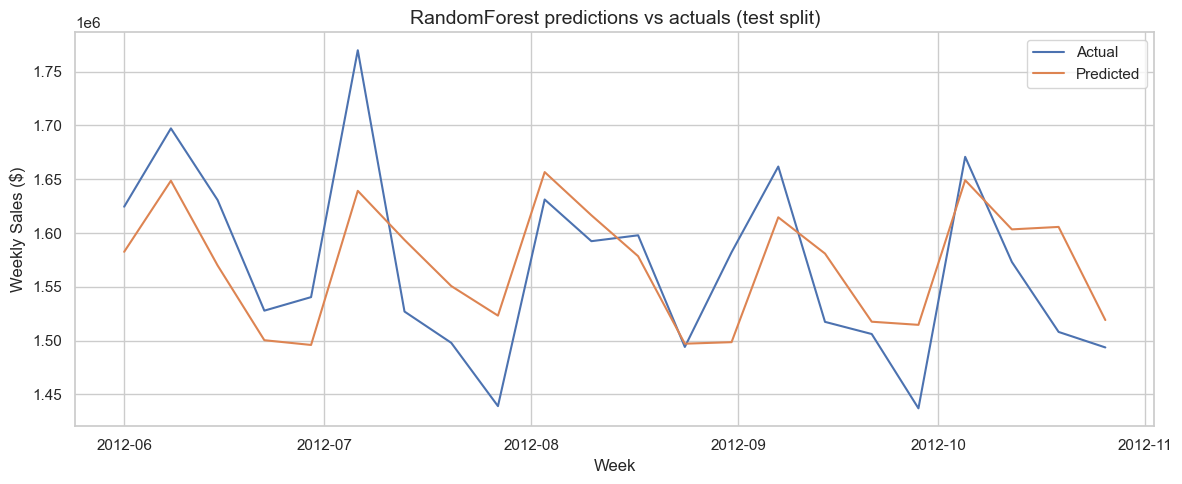

In [15]:
test_results = pd.DataFrame({"Date": test_dates, "Actual": y_test, "Predicted": pred_test})
plt.figure(figsize=(12, 5))
sns.lineplot(data=test_results, x="Date", y="Actual", label="Actual")
sns.lineplot(data=test_results, x="Date", y="Predicted", label="Predicted")
plt.title("RandomForest predictions vs actuals (test split)")
plt.xlabel("Week")
plt.ylabel("Weekly Sales ($)")
plt.legend()
plt.tight_layout()

,importance
week,0.366404
day,0.078184
CPI,0.074665
Weekly_Sales_lag_1_Store,0.060047
Weekly_Sales_lag_52_Store,0.055130
Weekly_Sales_rolling_mean_8_Store,0.038411
Weekly_Sales_rolling_mean_26_Store,0.034720
Weekly_Sales_rolling_mean_4_Store,0.031568
Temperature,0.031473
Weekly_Sales_lag_4_Store,0.028767


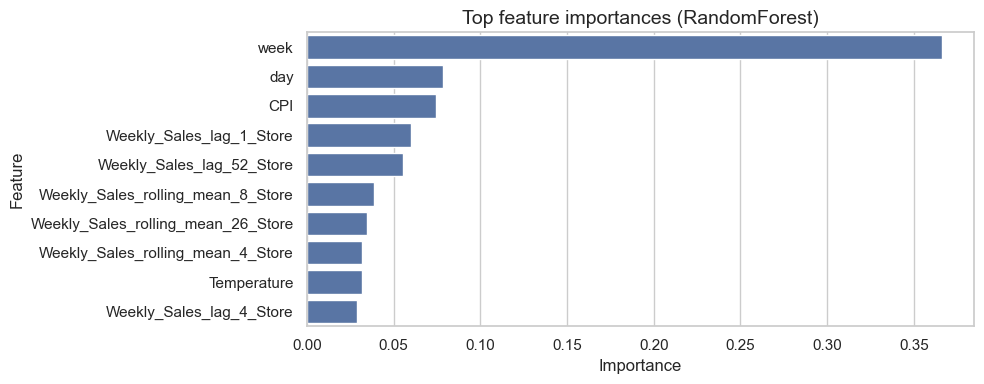

In [16]:
feature_importance = pd.Series(rf_model.feature_importances_, index=feature_cols)
top_features = feature_importance.sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 4))
sns.barplot(x=top_features.values, y=top_features.index, orient="h")
plt.title("Top feature importances (RandomForest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
top_features.to_frame(name="importance")

In [17]:
MODEL_PATH = MODEL_DIR / f"random_forest_store{TARGET_STORE}.joblib"
SCALER_PATH = MODEL_DIR / f"random_forest_store{TARGET_STORE}_scaler.joblib"
METRICS_PATH = MODEL_DIR / f"random_forest_store{TARGET_STORE}_metrics.parquet"

joblib.dump(rf_model, MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)
metrics_df.to_parquet(METRICS_PATH, index=False)

print(f"Model saved to {MODEL_PATH}")
print(f"Scaler saved to {SCALER_PATH}")
print(f"Metrics logged to {METRICS_PATH}")

NameError: name 'metrics_df' is not defined